# F1 Best Lap Analysis

### Import Libraries

In [41]:
import sys
import fastf1
fastf1.Cache.enable_cache(sys.path[0]+"/fastf1_cache") 
from fastf1 import plotting
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import datetime
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd
import numpy as np
from windrose import WindroseAxes
pd.set_option('display.max_columns', None)

### Load Race(Input Race Name and Year)

In [42]:
# input session and year
year = 2023
location = 'Barcelona'
session = 'Qualifying'

# get session
"""
    session identifier:
    'FP1', 'FP2', 'FP3', 'Q', 'S', 'SQ', 'SS', 'R
    'Practice 1', 'Practice 2', 'Practice 3', 'Sprint Qualifying', 'Sprint', 'Sprint Shootout', 'Qualifying', 'Race'
"""

race = fastf1.get_session(year, location, session)
race.load(weather=True)

core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.0.0]
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has

### Load Dataframe and Preprocessing

In [43]:
# load race laps
race_name = race.event.OfficialEventName
df = race.laps

# load dataframe of df (by Final Position in ascending order)
df = df.sort_values(by=['LapNumber','Position'], ascending=[False, True]).reset_index(drop=True)

# fill in empty laptime records and convert to seconds
df.LapTime = df.LapTime.fillna(df['Sector1Time']+df['Sector2Time']+df['Sector3Time'])
df.LapTime = df.LapTime.dt.total_seconds()
df.Sector1Time = df.Sector1Time.dt.total_seconds()
df.Sector2Time = df.Sector2Time.dt.total_seconds()
df.Sector3Time = df.Sector3Time.dt.total_seconds()

### Load Results and Gap Calculation

In [44]:
# Results
df_results = race.results
df_results['BestQTime'] = round(df_results.apply(lambda row: min(row.Q1, row.Q2, row.Q3), axis=1).dt.total_seconds(),3)
df_results['GapToBest'] = df_results.apply(lambda row: round(row.BestQTime - df_results.BestQTime.min(),3), axis=1)
df_results = df_results.sort_values('GapToBest')

### Gap to Best Driver

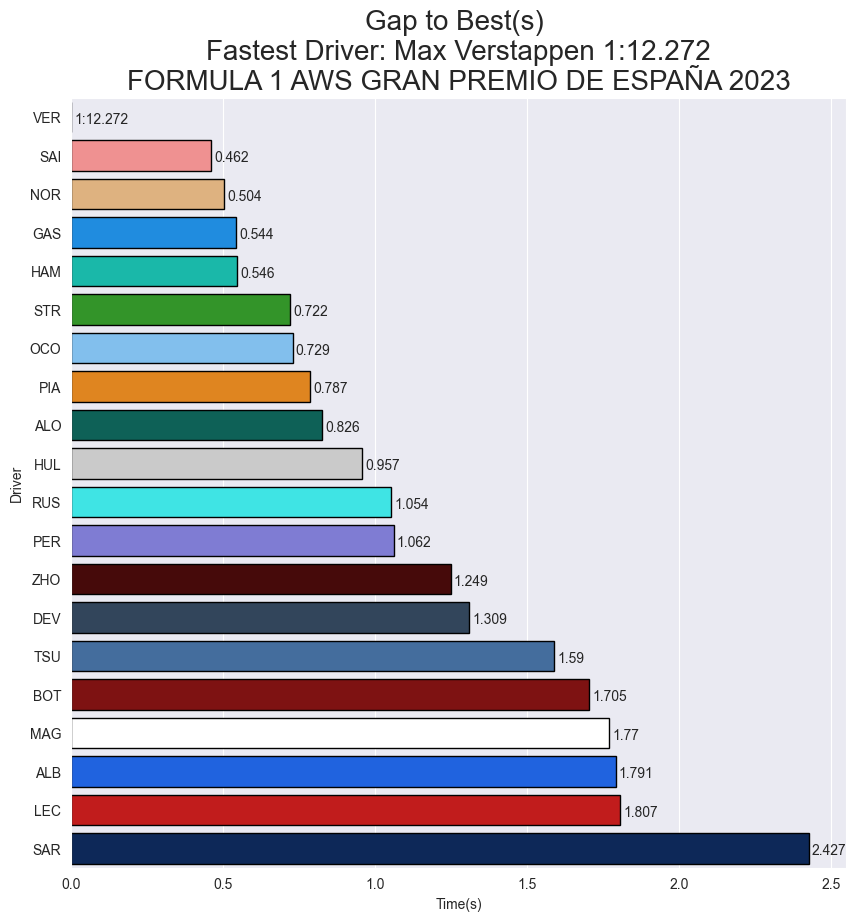

In [45]:
# for driver color palette
driver_color = {}
for index,row in df_results.iterrows():
    driver = row['Abbreviation']
    driver_color[driver] = fastf1.plotting.driver_color(driver)

plt.figure(figsize=(10,10))
sns.barplot(data=df_results, x='GapToBest', y='Abbreviation', palette=driver_color,  edgecolor='black')
plt.ylabel('Driver')
plt.xlabel('Time(s)')
plt.title(f'Gap to Best(s) \nFastest Driver: {df_results.FullName[0]} {int(df_results.BestQTime[0]/60)}:{round(df_results.BestQTime[0]-60,3)}\n{race_name}', fontsize=20)
# to add data labels
plt.text(df_results.GapToBest[0]+0.01, 0.15, f'{int(df_results.BestQTime[0]/60)}:{round(df_results.BestQTime[0]-60,3)}', ha = 'left') # for 1st driver
for i in range(1,len(df_results)):
    plt.text(df_results.GapToBest[i]+0.01, i+0.15, df_results.GapToBest[i], ha = 'left')  
plt.show()

### Telemetry Data for Fastest Drivers

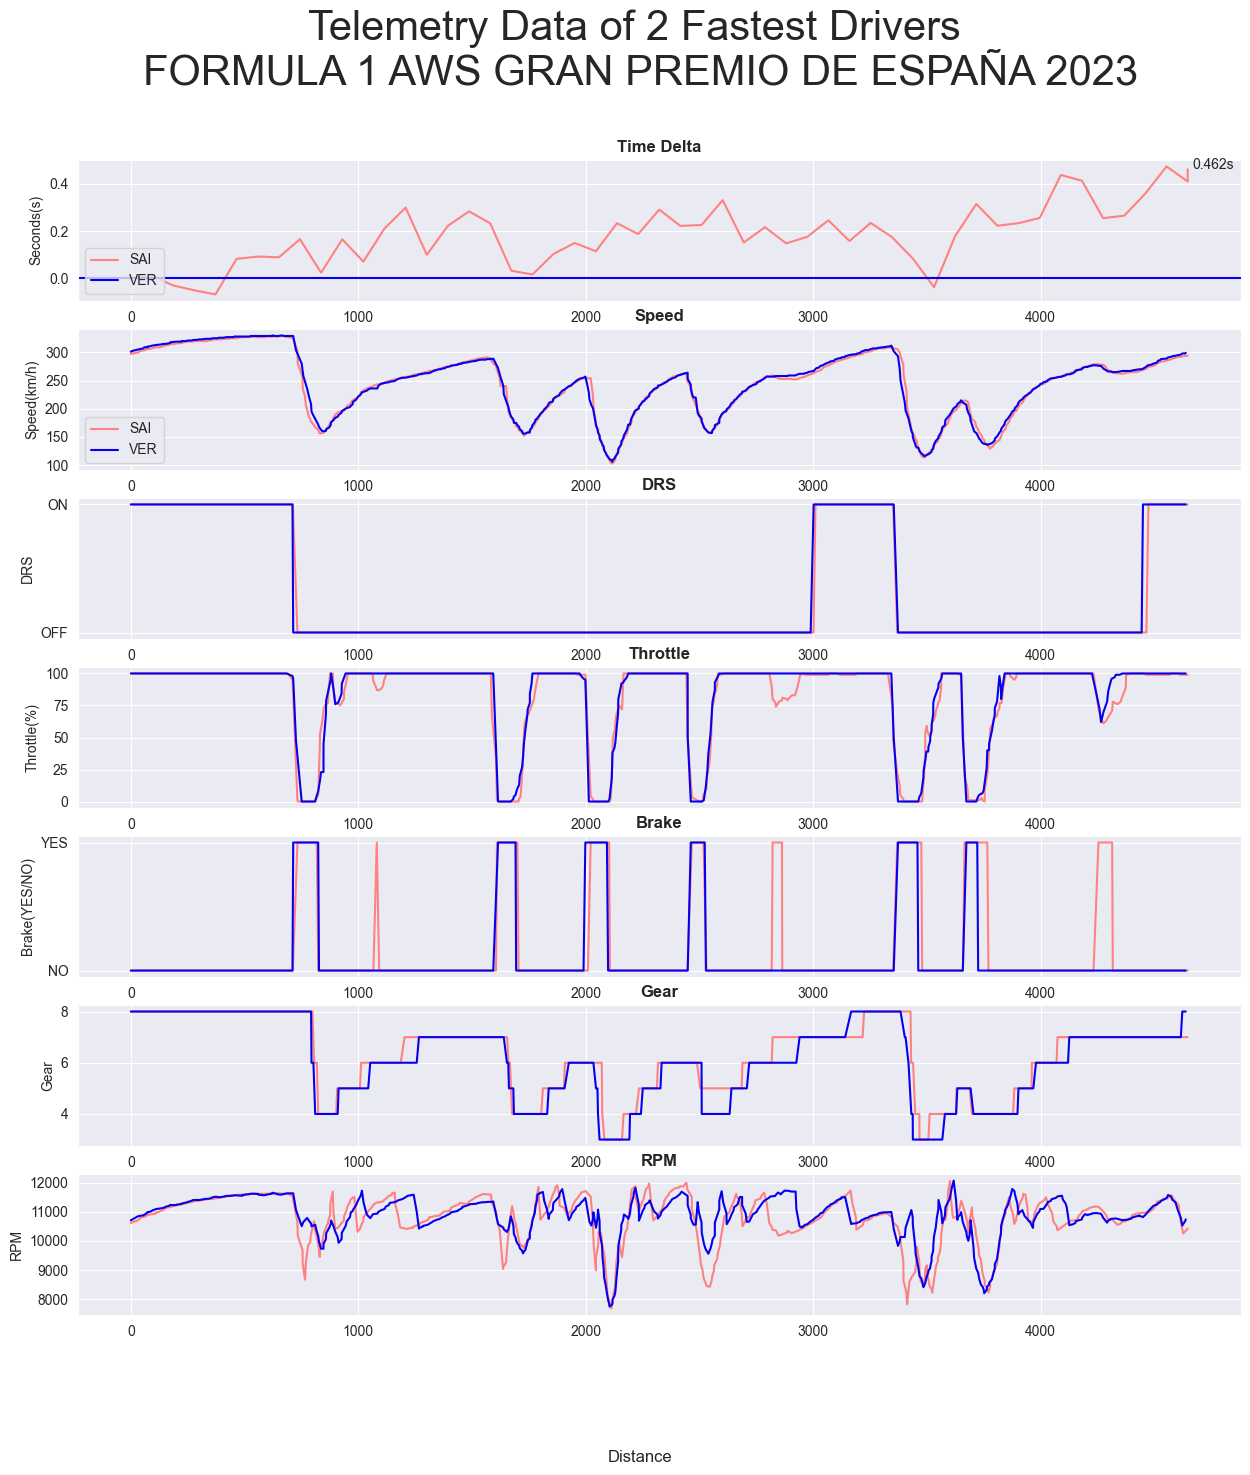

In [46]:
# get telemetry data
driver_1_lap = df.pick_driver(df_results.Abbreviation[0]).pick_fastest()
driver_1_tel = driver_1_lap.get_telemetry()
driver_1_tel['Driver'] = df_results.Abbreviation[0]
driver_2_lap = df.pick_driver(df_results.Abbreviation[1]).pick_fastest()
driver_2_tel = driver_2_lap.get_telemetry()
driver_2_tel['Driver'] = df_results.Abbreviation[1]
driver_3_lap = df.pick_driver(df_results.Abbreviation[2]).pick_fastest()
driver_3_tel = driver_3_lap.get_telemetry()
driver_3_tel['Driver'] = df_results.Abbreviation[2]

# data transform

# join all 3 drivers data
telemetry = pd.concat([driver_1_tel, driver_2_tel, driver_3_tel])

# creating minisectors
total_minisectors = 50
telemetry['Minisector'] = pd.cut(telemetry['Distance'], total_minisectors, labels = False) + 1

# calculate time delta for top 2 drivers
time_used = telemetry.groupby(['Minisector', 'Driver'])['Time'].mean().reset_index().rename(columns={'Time':'BestTime'})
time_used['BestDriverTime'] = time_used.apply(lambda x: time_used.loc[(time_used.Driver == df_results.Abbreviation[0]) & (time_used.Minisector == x.Minisector), 'BestTime'].min(), axis=1)
time_used['TimeDelta'] = time_used['BestTime'].dt.total_seconds() - time_used['BestDriverTime'].dt.total_seconds()

# PLOTTING!!!
fig, ax = plt.subplots(7, figsize=(15, 15))
fig.suptitle('Telemetry Data of 2 Fastest Drivers \n'+race_name, fontsize=30)
fig.supxlabel('Distance')

# Time Delta
second_driver_time_delta = [0] + time_used.loc[time_used.Driver == df_results.Abbreviation[1], 'TimeDelta'].to_list()+[df_results.GapToBest[1]]
distance_array = [0] + [i*telemetry.Distance.max()/total_minisectors for i in range(1,total_minisectors+1)] + [telemetry.Distance.max()]
ax[0].plot(distance_array, second_driver_time_delta, color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[0].axhline(y=0, color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0])
ax[0].text(max(distance_array)+20, df_results.GapToBest[1], f"{df_results.GapToBest[1]}s")
ax[0].legend(loc = 'lower left')
ax[0].set_title('Time Delta', fontweight="bold")
ax[0].set(ylabel= 'Seconds(s)')

# Speed
ax[1].plot(driver_2_tel['Distance'], driver_2_tel['Speed'], color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[1].plot(driver_1_tel['Distance'], driver_1_tel['Speed'], color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0])
ax[1].legend(loc = 'lower left')
ax[1].set_title('Speed', fontweight="bold")
ax[1].set(ylabel= 'Speed(km/h)')

# DRS
# transform DRS
driver_1_tel['DRS_Activated'] = driver_1_tel['DRS'].map(lambda x: 'ON' if x >= 10 else 'OFF')
driver_2_tel['DRS_Activated'] = driver_2_tel['DRS'].map(lambda x: 'ON' if x >= 10 else 'OFF')
ax[2].plot(driver_2_tel['Distance'], driver_2_tel['DRS_Activated'], color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[2].plot(driver_1_tel['Distance'], driver_1_tel['DRS_Activated'], color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0])
ax[2].invert_yaxis()
ax[2].set_title('DRS', fontweight="bold")
ax[2].set(ylabel= 'DRS')

# Throttle
ax[3].plot(driver_2_tel['Distance'], driver_2_tel['Throttle'], color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[3].plot(driver_1_tel['Distance'], driver_1_tel['Throttle'], color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0])
ax[3].set_title('Throttle', fontweight="bold")
ax[3].set(ylabel= 'Throttle(%)')

# Brake
ax[4].plot(driver_2_tel['Distance'], driver_2_tel['Brake'], color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[4].plot(driver_1_tel['Distance'], driver_1_tel['Brake'], color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0])
ax[4].set_yticks(ticks = [1,0], labels = ["YES", "NO"])
ax[4].set_title('Brake', fontweight="bold")
ax[4].set(ylabel= 'Brake(YES/NO)')

# Gear
ax[5].plot(driver_2_tel['Distance'], driver_2_tel['nGear'], color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[5].plot(driver_1_tel['Distance'], driver_1_tel['nGear'], color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0])
ax[5].set_title('Gear', fontweight="bold")
ax[5].set(ylabel= 'Gear')

# RPM
ax[6].plot(driver_2_tel['Distance'], driver_2_tel['RPM'], color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[6].plot(driver_1_tel['Distance'], driver_1_tel['RPM'], color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0])
ax[6].set_title('RPM', fontweight="bold")
ax[6].set(ylabel= 'RPM')

plt.show()

### Track Dominance

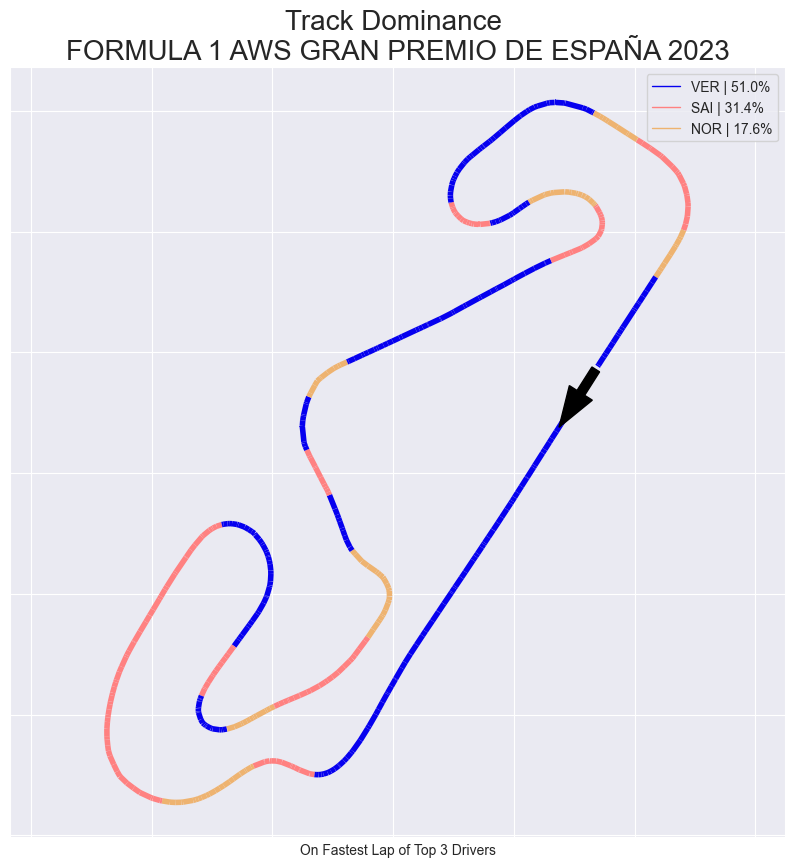

In [47]:
# Track Dominance
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()
best_sectors = average_speed.groupby(['Minisector'])['Speed'].max().reset_index()
best_sectors = best_sectors.merge(average_speed[['Speed','Driver']], on=['Speed']).rename(columns={'Driver':'FastestSectorDriver', 'Speed':'FastestSectorSpeed'})
track_dominance = best_sectors.FastestSectorDriver.value_counts(normalize=True)
best_sectors = best_sectors.merge(telemetry, on=['Minisector'])

# Get Lap Data
single_lap = telemetry.loc[telemetry['Driver'] == df_results.Abbreviation[0]]
lap_x = np.array(single_lap['X'].values)
lap_y = np.array(single_lap['Y'].values)

# points and segments for drawing lap
points = np.array([lap_x, lap_y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Get Fastest Driver of each minisector
best_sectors['FastestSectorDriver'] = best_sectors['FastestSectorDriver'].map({df_results.Abbreviation[0]:1,df_results.Abbreviation[1]:2,df_results.Abbreviation[2]:3})
map_sectors = best_sectors.loc[best_sectors['Driver'] == df_results.Abbreviation[0]]

# getting colormap
colors = [driver_color[df_results.Abbreviation[i]] for i in range(3)]
cmap = ListedColormap(colors)

# coordinates
lc_comp = LineCollection(segments, norm = plt.Normalize(1, cmap.N), cmap = cmap)
lc_comp.set_array(map_sectors['FastestSectorDriver'])
lc_comp.set_linewidth(4)

# plot
plt.rcParams['figure.figsize'] = [10,10]
plt.title('Track Dominance \n'+race_name, fontsize=20)
plt.xlabel('On Fastest Lap of Top 3 Drivers')
plt.gca().add_collection(lc_comp)
plt.arrow(lap_x[0], lap_y[0], lap_x[5]-lap_x[0], lap_y[5]-lap_y[0], width=150, color='black', zorder=100)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
legend_lines = [Line2D([0], [0], color = driver_color[df_results.Abbreviation[i]], lw = 1) for i in range(3)]
plt.legend(legend_lines, 
           [f"{df_results.Abbreviation[0]} | {round(track_dominance[df_results.Abbreviation[0]]*100,1)}%", 
            f"{df_results.Abbreviation[1]} | {round(track_dominance[df_results.Abbreviation[1]]*100,1)}%", 
            f"{df_results.Abbreviation[2]} | {round(track_dominance[df_results.Abbreviation[2]]*100,1)}%"])
plt.show()

### Fastest Drivers in Each Sector

Text(0.5, 1.0, 'Sector 3')

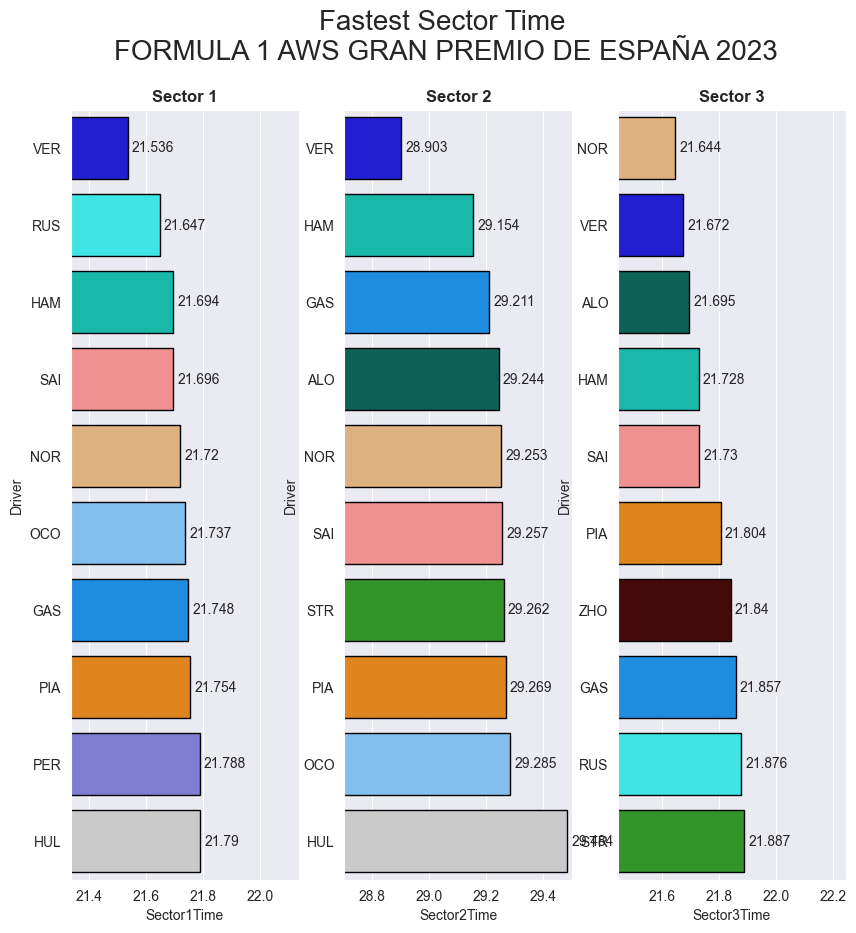

In [48]:
# Get the top 10 fastest SectorTime
top_10_sector1 = df.groupby(['Driver'])['Sector1Time'].min().sort_values().head(10).reset_index()
top_10_sector2 = df.groupby(['Driver'])['Sector2Time'].min().sort_values().head(10).reset_index()
top_10_sector3 = df.groupby(['Driver'])['Sector3Time'].min().sort_values().head(10).reset_index()

fig, ax = plt.subplots(1,3, figsize=(10, 10))
fig.suptitle('Fastest Sector Time \n'+race_name, fontsize=20)

# Sector 1
sns.barplot(x=top_10_sector1['Sector1Time'], y=top_10_sector1['Driver'], palette=driver_color, ax=ax[0], edgecolor='black')
ax[0].bar_label(ax[0].containers[0], padding=3)
ax[0].set_xlim(top_10_sector1.Sector1Time[0]-0.2,top_10_sector1.Sector1Time[0]+0.6)
ax[0].set_title('Sector 1', fontweight="bold")

# Sector 2
sns.barplot(x=top_10_sector2['Sector2Time'], y=top_10_sector2['Driver'], palette=driver_color, ax=ax[1], edgecolor='black')
ax[1].bar_label(ax[1].containers[0], padding=3)
ax[1].set_xlim(top_10_sector2.Sector2Time[0]-0.2,top_10_sector2.Sector2Time[0]+0.6)
ax[1].set_title('Sector 2', fontweight="bold")

# Sector 3
sns.barplot(x=top_10_sector3['Sector3Time'], y=top_10_sector3['Driver'], palette=driver_color, ax=ax[2], edgecolor='black')
ax[2].bar_label(ax[2].containers[0], padding=3)
ax[2].set_xlim(top_10_sector3.Sector3Time[0]-0.2,top_10_sector3.Sector3Time[0]+0.6)
ax[2].set_title('Sector 3', fontweight="bold")

### Top Speed and Min Speed of Each Team

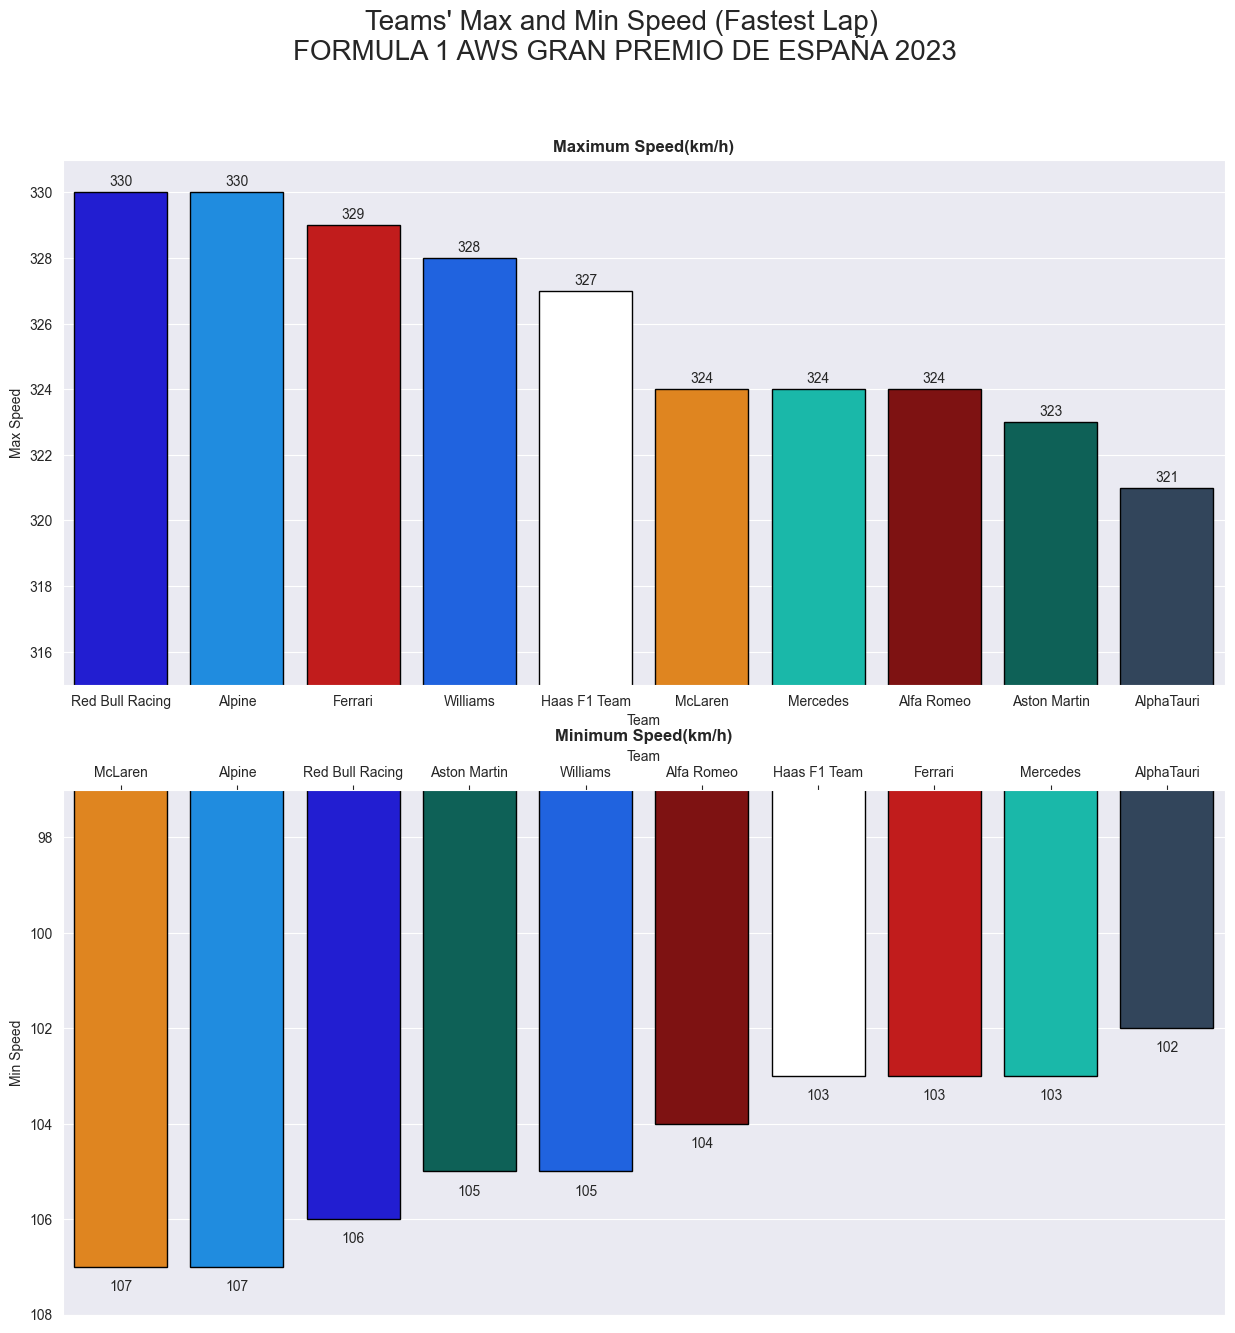

In [49]:
# top speed and min speed of each team
team_max_speed = {}
team_min_speed = {}

for team in set(df.Team):
    team_max_speed[team] = df.pick_team(team).pick_fastest().get_telemetry().Speed.max()
    team_min_speed[team] = df.pick_team(team).pick_fastest().get_telemetry().Speed.min()

team_max_speed = pd.DataFrame(team_max_speed.items(), columns=['Team', 'Max Speed']).sort_values('Max Speed', ascending=False).reset_index()
team_min_speed = pd.DataFrame(team_min_speed.items(), columns=['Team', 'Min Speed']).sort_values('Min Speed', ascending=False).reset_index()

# for colour palette
team_color = {}
for team in team_max_speed.Team:
    team_color[team] = fastf1.plotting.team_color(team)

fig, ax = plt.subplots(2, figsize=(15, 15))
fig.suptitle('Teams\' Max and Min Speed (Fastest Lap) \n'+race_name, fontsize=20)

# Max Speed
sns.barplot(data=team_max_speed, x='Team', y='Max Speed' , palette=team_color, ax=ax[0], edgecolor='black')
ax[0].set_ylim(team_max_speed['Max Speed'].max()-15, team_max_speed['Max Speed'].max()+1)
ax[0].set_title('Maximum Speed(km/h)', fontweight="bold")
# to add data labels
for i in range(len(team_max_speed)):
    ax[0].text(i, team_max_speed['Max Speed'][i]+0.2, team_max_speed['Max Speed'][i], ha = 'center')  

# Min Speed
sns.barplot(data=team_min_speed, x='Team', y='Min Speed' , palette=team_color, ax=ax[1], edgecolor='black')
ax[1].set_ylim(team_min_speed['Min Speed'].max()-10, team_min_speed['Min Speed'].max()+1)
ax[1].set_title('Minimum Speed(km/h)', fontweight="bold")
ax[1].invert_yaxis()
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top') 
# to add data labels
for i in range(len(team_min_speed)):
    ax[1].text(i, team_min_speed['Min Speed'][i]+0.5, team_min_speed['Min Speed'][i], ha = 'center')  

### General Weather Data & Track Evolution

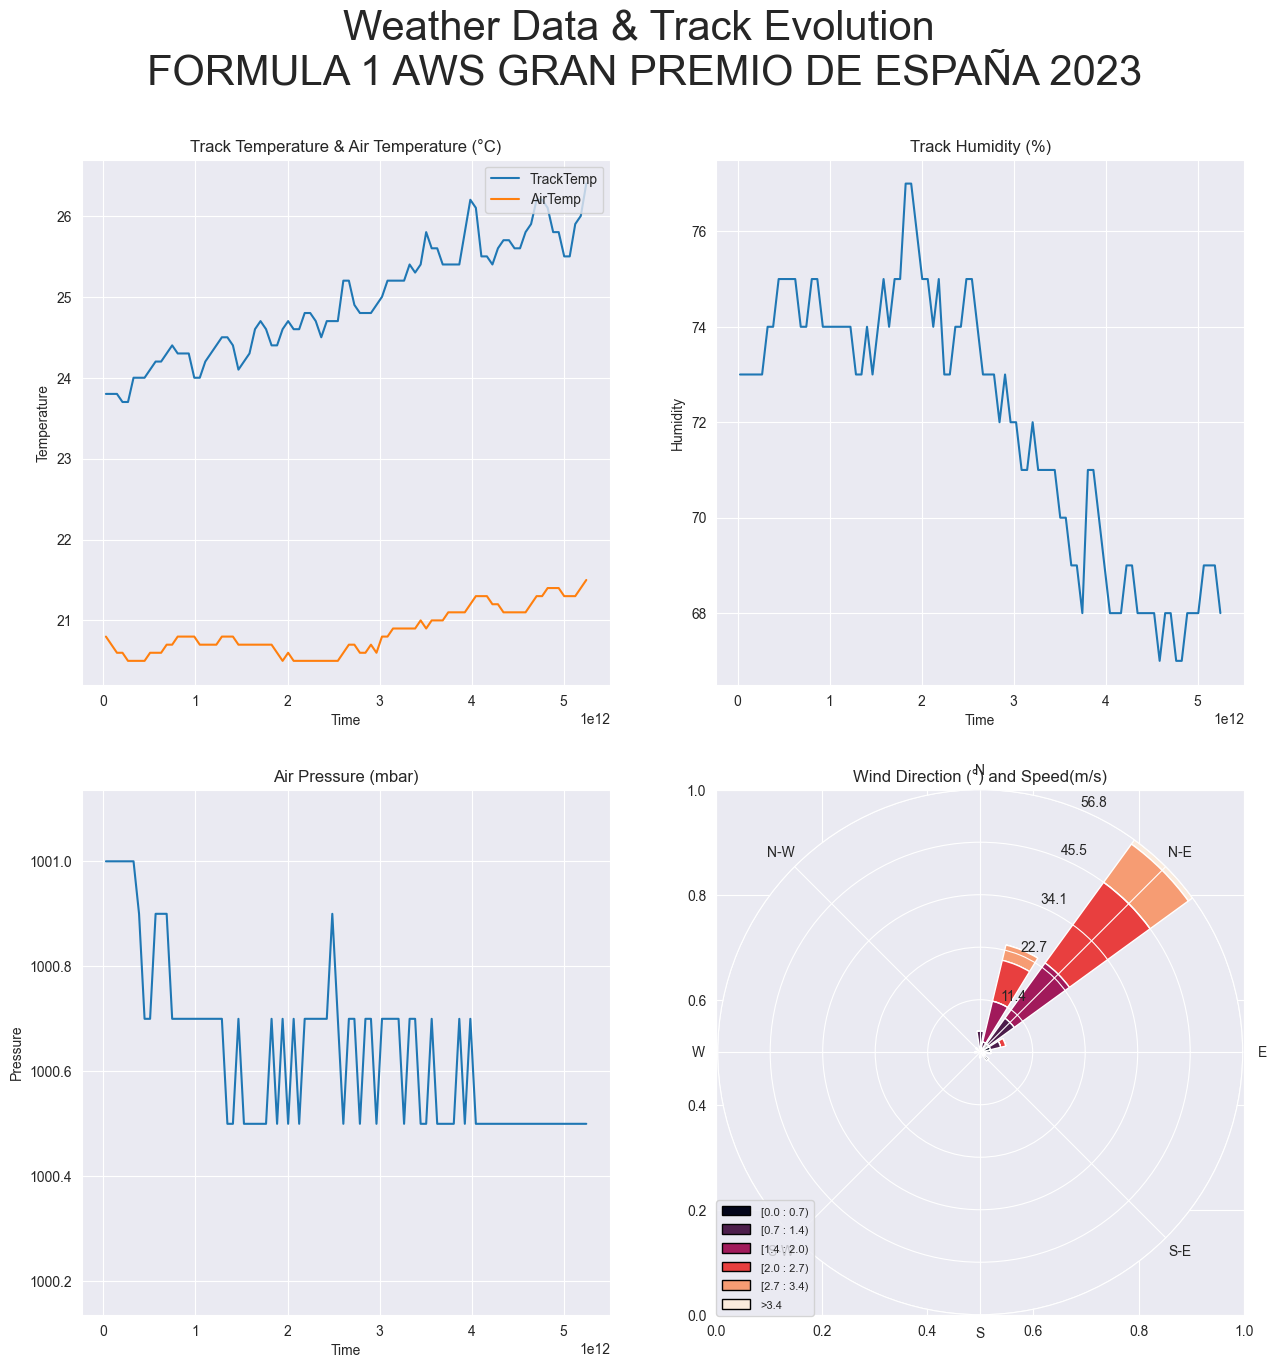

In [51]:
fig, ax = plt.subplots(2,2, figsize=(15, 15))
fig.suptitle('Weather Data & Track Evolution \n'+race_name, fontsize=30)

# Track and Air Temperature
sns.lineplot(data = race.weather_data, x='Time', y='TrackTemp', label = 'TrackTemp', ax = ax[0,0])
sns.lineplot(data = race.weather_data, x='Time', y='AirTemp', label = 'AirTemp', ax = ax[0,0])
ax[0,0].legend(loc='upper right')
ax[0,0].set_ylabel('Temperature')
ax[0,0].title.set_text('Track Temperature & Air Temperature (°C)')

# Humidity
sns.lineplot(race.weather_data, x='Time', y='Humidity', ax=ax[0,1])
ax[0,1].title.set_text('Track Humidity (%)')

# Pressure
sns.lineplot(data = race.weather_data, x='Time', y='Pressure', ax = ax[1,0])
ax[1,0].set_ylim(race.weather_data.Pressure.mean()-0.5,race.weather_data.Pressure.mean()+0.5)
ax[1,0].title.set_text('Air Pressure (mbar)')

# Wind Direction & Speed
rect = ax[1,1].get_position()
wax = WindroseAxes(fig, rect)
fig.add_axes(wax)
wax.bar(race.weather_data.WindDirection, race.weather_data.WindSpeed, normed=True, opening=0.8, edgecolor='white')
wax.set_legend()
ax[1,1].title.set_text('Wind Direction (°) and Speed(m/s)')
